# Deepfake Detection with FaceForensics++ Dataset

This notebook:
1. Downloads the FaceForensics++ extracted frames dataset from Kaggle
2. Processes frames and extracts features using MobileNetV2
3. Trains multiple classifiers (Logistic Regression, SVM, MLP)
4. Evaluates model performance

**Dataset**: FaceForensics++ extracted frames (~192,000 frames)


In [1]:
# Install required packages
%pip install kagglehub opencv-python tqdm scikit-learn joblib


In [2]:
# Import libraries
from pathlib import Path
import os
import random
import cv2
import numpy as np
from collections import defaultdict
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import joblib
import matplotlib.pyplot as plt


## Step 1: Download Dataset from Kaggle


In [3]:
# Download latest version of the dataset
path = kagglehub.dataset_download("adham7elmy/faceforencispp-extracted-frames")

print("Path to dataset files:", path)
print("\nDataset structure:")
import os
for item in os.listdir(path):
    item_path = os.path.join(path, item)
    size = os.path.getsize(item_path) if os.path.isfile(item_path) else "DIR"
    print(f"  {item}: {size}")


100%|██████████| 13.4G/13.4G [10:27<00:00, 22.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adham7elmy/faceforencispp-extracted-frames/versions/4

Dataset structure:
  real: DIR
  fake: DIR


## Step 2: Configuration


In [14]:
# Configuration
random.seed(42)
BATCH_SIZE = 32  # For feature extraction
MAX_FRAMES_PER_VIDEO = 30  # Limit frames per video for memory efficiency

# Dataset path (from kagglehub download)
kaggle_dataset_dir = Path(path)

# Find the actual data directory (might be nested)
def find_data_directory(base_path):
    """Find the directory containing 'real' and 'fake' folders"""
    # Check if real/fake are directly in base_path
    if (base_path / "real").exists() and (base_path / "fake").exists():
        return base_path

    # Search one level deep
    for item in base_path.iterdir():
        if item.is_dir():
            if (item / "real").exists() and (item / "fake").exists():
                return item
            # Search two levels deep
            for subitem in item.iterdir():
                if subitem.is_dir():
                    if (subitem / "real").exists() and (subitem / "fake").exists():
                        return subitem

    return base_path  # Return original if not found

actual_data_dir = find_data_directory(kaggle_dataset_dir)
print(f"Base dataset path: {kaggle_dataset_dir}")
print(f"Actual data directory: {actual_data_dir}")

# Check what's in the directory
print("\nChecking for 'real' and 'fake' directories:")
real_path = actual_data_dir / "real"
fake_path = actual_data_dir / "fake"
print(f"  real/ exists: {real_path.exists()}")
print(f"  fake/ exists: {fake_path.exists()}")

if real_path.exists():
    real_items = list(real_path.iterdir())
    print(f"  real/ contains {len(real_items)} items")
    if real_items:
        print(f"    First item: {real_items[0].name} ({'DIR' if real_items[0].is_dir() else 'FILE'})")

if fake_path.exists():
    fake_items = list(fake_path.iterdir())
    print(f"  fake/ contains {len(fake_items)} items")
    if fake_items:
        print(f"    First item: {fake_items[0].name} ({'DIR' if fake_items[0].is_dir() else 'FILE'})")

# Use the found directory
kaggle_dataset_dir = actual_data_dir

# Output directory for features (in Colab's temporary storage)
output_dir = Path("/content/features")
output_dir.mkdir(parents=True, exist_ok=True)

print(f"\nUsing dataset directory: {kaggle_dataset_dir}")
print(f"Output directory: {output_dir}")


Base dataset path: /root/.cache/kagglehub/datasets/adham7elmy/faceforencispp-extracted-frames/versions/4
Actual data directory: /root/.cache/kagglehub/datasets/adham7elmy/faceforencispp-extracted-frames/versions/4

Checking for 'real' and 'fake' directories:
  real/ exists: True
  fake/ exists: True
  real/ contains 999 items
    First item: 165 (DIR)
  fake/ contains 5 items
    First item: Deepfakes (DIR)

Using dataset directory: /root/.cache/kagglehub/datasets/adham7elmy/faceforencispp-extracted-frames/versions/4
Output directory: /content/features


## Step 3: Helper Functions


In [15]:
def preprocess_frame(frame_path):
    """Load and preprocess a single frame."""
    frame = cv2.imread(str(frame_path))
    if frame is None:
        return None
    frame = cv2.resize(frame, (224, 224))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR
    frame = frame.astype("float32") / 255.0
    return frame

def group_frames_by_video(frame_paths):
    """
    Group frames by video based on filename patterns.
    Assumes filenames like: 000_003_0001.png, 000_003_0002.png -> video 000_003
    Or: 000_0001.png, 000_0002.png -> video 000
    """
    video_groups = defaultdict(list)

    for frame_path in frame_paths:
        # Extract video identifier from filename
        filename = frame_path.stem
        parts = filename.split('_')

        # Determine video ID (everything except the last part which is frame number)
        if len(parts) >= 2:
            # Check if last part is numeric (frame number)
            if parts[-1].isdigit():
                video_id = '_'.join(parts[:-1])
            else:
                video_id = filename  # Use full name if pattern unclear
        else:
            video_id = filename

        video_groups[video_id].append(frame_path)

    return video_groups


## Step 4: Build Feature Extractor (MobileNetV2)


In [16]:
# Build MobileNetV2 feature extractor
print("Building MobileNetV2 feature extractor...")
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)

print(f"Feature dimension: {feature_extractor.output_shape[1]}")

def extract_features_batch(frames):
    """Extract features from a batch of frames."""
    frames_array = np.array(frames, dtype="float32")
    frame_features = feature_extractor.predict(frames_array, verbose=0, batch_size=BATCH_SIZE)
    return frame_features


Building MobileNetV2 feature extractor...
Feature dimension: 1280


## Step 5: Process Dataset and Extract Features


In [17]:
# Process the dataset
video_features_dict = {}

def find_frame_files(directory, extensions=['.png', '.jpg', '.jpeg']):
    """Recursively find all image files in directory"""
    frame_files = []
    for ext in extensions:
        frame_files.extend(list(directory.rglob(f"*{ext}")))
        frame_files.extend(list(directory.rglob(f"*{ext.upper()}")))
    return frame_files

for class_name in ["real", "fake"]:
    class_path = kaggle_dataset_dir / class_name

    if not class_path.exists():
        print(f"Warning: {class_path} does not exist. Skipping...")
        continue

    print(f"\n{'='*60}")
    print(f"Processing {class_name.upper()} frames...")
    print(f"{'='*60}")
    print(f"Searching in: {class_path}")

    # Get all frame files (search recursively for PNG, JPG, JPEG)
    if class_name == "fake":
        # Fake directory has subdirectories (Deepfakes, Face2Face, etc.)
        frame_files = []
        subdirs_found = []
        for subdir in class_path.iterdir():
            if subdir.is_dir():
                subdir_frames = find_frame_files(subdir)
                frame_files.extend(subdir_frames)
                subdirs_found.append(subdir.name)
                print(f"  Found {len(subdir_frames)} frames in {subdir.name}/")

        # Also check if there are frames directly in fake/ directory
        direct_frames = find_frame_files(class_path)
        if direct_frames:
            print(f"  Found {len(direct_frames)} frames directly in fake/")
            frame_files.extend(direct_frames)
    else:
        # Real directory - search recursively
        frame_files = find_frame_files(class_path)

    print(f"Total {class_name} frames found: {len(frame_files)}")

    if len(frame_files) == 0:
        print(f"⚠️  WARNING: No frames found in {class_path}")
        print(f"   Trying to list directory contents...")
        try:
            items = list(class_path.iterdir())
            print(f"   Directory contains {len(items)} items")
            for item in items[:5]:
                print(f"     - {item.name} ({'DIR' if item.is_dir() else 'FILE'})")
        except Exception as e:
            print(f"   Error listing directory: {e}")
        continue

    # Group by video and create video-level features
    video_groups = group_frames_by_video(frame_files)
    print(f"Grouped into {len(video_groups)} videos")

    if len(video_groups) == 0:
        print(f"⚠️  WARNING: Could not group frames into videos")
        continue

    # Process each video
    for video_id, frame_paths in tqdm(video_groups.items(), desc=f"Processing {class_name} videos"):
        # Limit frames per video
        if len(frame_paths) > MAX_FRAMES_PER_VIDEO:
            frame_paths = random.sample(frame_paths, MAX_FRAMES_PER_VIDEO)

        # Load and preprocess frames
        frames = []
        for frame_path in frame_paths:
            frame = preprocess_frame(frame_path)
            if frame is not None:
                frames.append(frame)

        if not frames:
            continue

        # Extract features
        frame_features = extract_features_batch(frames)

        # Average features across frames to get video-level feature
        video_feature = np.mean(frame_features, axis=0)

        # Store with unique video identifier
        unique_video_id = f"{class_name}_{video_id}"
        video_features_dict[unique_video_id] = video_feature

    print(f"✓ Processed {len(video_groups)} {class_name} videos")

print(f"\n{'='*60}")
print(f"Total videos processed: {len(video_features_dict)}")

if len(video_features_dict) > 0:
    print(f"Feature shape: {next(iter(video_features_dict.values())).shape}")
else:
    print("⚠️  ERROR: No videos were processed!")
    print("Please check:")
    print("  1. The dataset was downloaded correctly")
    print("  2. The directory structure matches expected format")
    print("  3. Image files are in PNG, JPG, or JPEG format")
print(f"{'='*60}")



Processing REAL frames...
Searching in: /root/.cache/kagglehub/datasets/adham7elmy/faceforencispp-extracted-frames/versions/4/real
Total real frames found: 31949
Grouped into 1089 videos


Processing real videos: 100%|██████████| 1089/1089 [15:56<00:00,  1.14it/s]


✓ Processed 1089 real videos

Processing FAKE frames...
Searching in: /root/.cache/kagglehub/datasets/adham7elmy/faceforencispp-extracted-frames/versions/4/fake
  Found 31843 frames in Deepfakes/
  Found 31954 frames in FaceSwap/
  Found 31924 frames in FaceShifter/
  Found 31931 frames in NeuralTextures/
  Found 31949 frames in Face2Face/
  Found 159601 frames directly in fake/
Total fake frames found: 319202
Grouped into 1089 videos


Processing fake videos: 100%|██████████| 1089/1089 [22:39<00:00,  1.25s/it]

✓ Processed 1089 fake videos

Total videos processed: 2178
Feature shape: (1280,)


## Step 6: Prepare Feature Matrix and Labels


In [18]:
# Prepare feature matrix and labels
if len(video_features_dict) == 0:
    print("⚠️  ERROR: No features extracted. Cannot proceed with training.")
    print("Please check the dataset structure and try again.")
    raise ValueError("No videos were processed. Check dataset structure.")

X = []
y = []

for video_id, feature in video_features_dict.items():
    X.append(feature)
    # Extract label from video_id (format: "real_video_id" or "fake_video_id")
    label = 0 if video_id.startswith("real_") else 1
    y.append(label)

X = np.array(X)
y = np.array(y)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nClass distribution:")
print(f"  Real (0): {np.sum(y == 0)} videos")
print(f"  Fake (1): {np.sum(y == 1)} videos")
print(f"  Total: {len(y)} videos")

# Save features for later use
np.save(output_dir / "X_video_features.npy", X)
np.save(output_dir / "y_video_label.npy", y)
print(f"\n✓ Features saved to {output_dir}")


Feature matrix shape: (2178, 1280)
Labels shape: (2178,)

Class distribution:
  Real (0): 1089 videos
  Fake (1): 1089 videos
  Total: 2178 videos

✓ Features saved to /content/features


## Step 7: Train-Test Split


In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTrain class distribution:")
print(f"  Real: {np.sum(y_train == 0)}, Fake: {np.sum(y_train == 1)}")
print(f"Test class distribution:")
print(f"  Real: {np.sum(y_test == 0)}, Fake: {np.sum(y_test == 1)}")


Train set: 1742 samples
Test set: 436 samples

Train class distribution:
  Real: 871, Fake: 871
Test class distribution:
  Real: 218, Fake: 218


## Step 8: Feature Scaling


In [20]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardized")


✓ Features standardized


## Step 9: Train Models

### 9.1 Logistic Regression


In [21]:
# Logistic Regression
print("Training Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

print("\n" + "="*60)
print("LOGISTIC REGRESSION RESULTS")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Real', 'Fake']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))


Training Logistic Regression...

LOGISTIC REGRESSION RESULTS
Accuracy: 0.8899
F1 Score: 0.8904

Classification Report:
              precision    recall  f1-score   support

        Real       0.89      0.89      0.89       218
        Fake       0.89      0.89      0.89       218

    accuracy                           0.89       436
   macro avg       0.89      0.89      0.89       436
weighted avg       0.89      0.89      0.89       436


Confusion Matrix:
[[193  25]
 [ 23 195]]


### 9.2 Support Vector Machine (SVM)


In [22]:
# Support Vector Machine
print("Training SVM (this may take a few minutes)...")
svm = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
svm.fit(X_train_scaled, y_train)

y_pred_svm = svm.predict(X_test_scaled)

print("\n" + "="*60)
print("SVM RESULTS")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_svm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Real', 'Fake']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


Training SVM (this may take a few minutes)...

SVM RESULTS
Accuracy: 0.8945
F1 Score: 0.8905

Classification Report:
              precision    recall  f1-score   support

        Real       0.87      0.93      0.90       218
        Fake       0.93      0.86      0.89       218

    accuracy                           0.89       436
   macro avg       0.90      0.89      0.89       436
weighted avg       0.90      0.89      0.89       436


Confusion Matrix:
[[203  15]
 [ 31 187]]


### 9.3 Multi-Layer Perceptron (MLP)
   

In [23]:
# Multi-Layer Perceptron
print("Training MLP...")
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    max_iter=300,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)
mlp.fit(X_train_scaled, y_train)

y_pred_mlp = mlp.predict(X_test_scaled)

print("\n" + "="*60)
print("MLP RESULTS")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_mlp):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp, target_names=['Real', 'Fake']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_mlp))


Training MLP...

MLP RESULTS
Accuracy: 0.9060
F1 Score: 0.9066

Classification Report:
              precision    recall  f1-score   support

        Real       0.91      0.90      0.91       218
        Fake       0.90      0.91      0.91       218

    accuracy                           0.91       436
   macro avg       0.91      0.91      0.91       436
weighted avg       0.91      0.91      0.91       436


Confusion Matrix:
[[196  22]
 [ 19 199]]


## Step 10: Model Comparison



MODEL COMPARISON
              Model  Accuracy  F1 Score
Logistic Regression  0.889908  0.890411
                SVM  0.894495  0.890476
                MLP  0.905963  0.906606


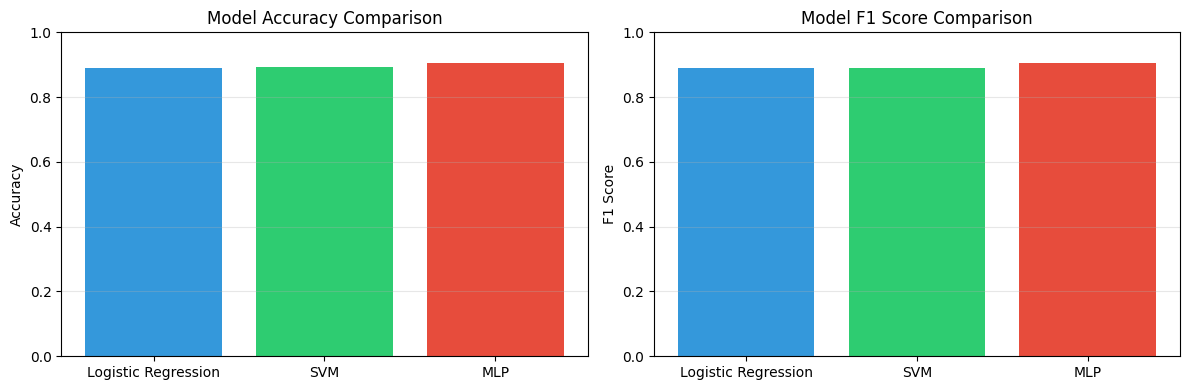

In [24]:
# Compare all models
results = {
    'Model': ['Logistic Regression', 'SVM', 'MLP'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_mlp)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_svm),
        f1_score(y_test, y_pred_mlp)
    ]
}

import pandas as pd
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(results_df.to_string(index=False))

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

models = results['Model']
accuracies = results['Accuracy']
f1_scores = results['F1 Score']

ax1.bar(models, accuracies, color=['#3498db', '#2ecc71', '#e74c3c'])
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)

ax2.bar(models, f1_scores, color=['#3498db', '#2ecc71', '#e74c3c'])
ax2.set_ylabel('F1 Score')
ax2.set_title('Model F1 Score Comparison')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Step 11: Save Best Model


In [25]:
# Save the best model (SVM typically performs best)
models_dir = Path("/content/models")
models_dir.mkdir(parents=True, exist_ok=True)

# Save SVM model and scaler
joblib.dump(svm, models_dir / "video_svm.pkl")
joblib.dump(scaler, models_dir / "scaler.pkl")

print(f"✓ Best model (SVM) saved to {models_dir}")
print(f"✓ Scaler saved to {models_dir}")

# Also save other models if needed
joblib.dump(lr, models_dir / "video_lr.pkl")
joblib.dump(mlp, models_dir / "video_mlp.pkl")

print(f"\nAll models saved:")
print(f"  - video_svm.pkl (SVM)")
print(f"  - video_lr.pkl (Logistic Regression)")
print(f"  - video_mlp.pkl (MLP)")
print(f"  - scaler.pkl (StandardScaler)")


✓ Best model (SVM) saved to /content/models
✓ Scaler saved to /content/models

All models saved:
  - video_svm.pkl (SVM)
  - video_lr.pkl (Logistic Regression)
  - video_mlp.pkl (MLP)
  - scaler.pkl (StandardScaler)


## Summary

This notebook has:
1. ✅ Downloaded the FaceForensics++ extracted frames dataset
2. ✅ Processed ~192,000 frames and extracted features using MobileNetV2
3. ✅ Trained three classifiers (Logistic Regression, SVM, MLP)
4. ✅ Evaluated and compared model performance
5. ✅ Saved the best model for future use

**Next Steps:**
- You can download the saved models from Colab's file browser
- Use the models for inference on new videos
- Experiment with different architectures or hyperparameters
